In [1]:
#Authors: Mitchell Montanio, Erin Vasut, Justin Joseph

In [2]:
# Import all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [3]:
# Read heartdisease.csv dataset into df
df = pd.read_csv('heartdisease.csv')

In [4]:
# Explore the data with info, looking for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [5]:
# Split the dataset for comparisons between two different approaches to handling the nulls
# df2 drops rows with nulls
df2=df.dropna()

# Fill nulls in df with either mean or mode of row, depending on values listed in df.describe() and direct query of columns
df['education'].fillna(1.0, inplace=True)
df['cigsPerDay'].fillna(9.0, inplace=True)
df['BPMeds'].fillna(0.0,inplace=True)
df['totChol'].fillna(237.0,inplace=True)
df['BMI'].fillna(25.80,inplace=True)
df['heartRate'].fillna(75.0,inplace=True)
df['glucose'].fillna(82.0,inplace=True)

In [6]:
# Create a function that creates a new column with binned blood pressure ranges based on information from medical professionals
def add_bpRanges(x):
    criteria = [(x['sysBP'] < 120) & (x['diaBP'] < 80),
                (x['sysBP'].between(120,129.99)) & (x['diaBP'] < 80),
                (x['sysBP'].between(130,139.99)) | (x['diaBP'].between(80,89.99)),
                (x['sysBP'].between(140,180)) | (x['diaBP'].between(90, 120)),
                (x['sysBP'] > 180) | (x['diaBP'] > 120)]
    values = ['normal', 'elevated', 'HBP_s1', 'HBP_s2', 'HC']
    x['bpRanges'] = np.select(criteria, values)

# Create a function that creates a new column with binned ages in increments of 10
def add_ageRanges(x):
    age_bins = [30, 39, 49, 59, 69, 79]
    age_names = ["30s", "40s", "50s", "60s", "70s"]
    x['ageRanges'] = pd.cut(x['age'], age_bins, labels = age_names, include_lowest=True)

# Create a function that creates a new column with binned cholesterol ranges based on information from medical professionals
def add_cholRanges(x):
    chol_bins = [0, 199, 239, 700]
    chol_names = ["Good", "Elevated", "High"]
    x["cholRanges"] = pd.cut(x["totChol"], chol_bins, labels = chol_names, include_lowest=True)

In [7]:
# Run functions for df and df2
add_bpRanges(df)
add_bpRanges(df2)
add_ageRanges(df)
add_ageRanges(df2)
add_cholRanges(df)
add_cholRanges(df2)

<ipython-input-6-bd505167b452>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bpRanges'] = np.select(criteria, values)
<ipython-input-6-bd505167b452>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ageRanges'] = pd.cut(x['age'], age_bins, labels = age_names, include_lowest=True)
<ipython-input-6-bd505167b452>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

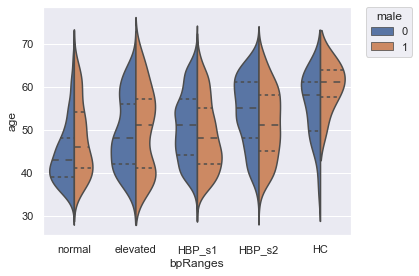

In [8]:
# Create visualization for bpRanges vs. age with a split on male
labels = np.array(['normal', 'elevated', 'HBP_s1', 'HBP_s2', 'HC'])
sns.violinplot(data=df2, x='bpRanges', y='age', order=labels, inner='quart', hue='male',split=True)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.,title='male')
plt.tight_layout()
plt.show()

In [9]:
# Create new dataframe that converts all strings to numeric values
df3 = pd.get_dummies(df2, columns=['bpRanges'])
df3.rename(columns={'bpRanges_HBP_s1':'HBP_s1',
                    'bpRanges_HBP_s2':'HBP_s2',
                    'bpRanges_HC':'bpHC',
                    'bpRanges_normal':'bpNormal', 
                    'bpRanges_elevated':'bpElevated'}, inplace=True)
df3['numBPRanges']=df2['bpRanges'].replace(['normal','elevated','HBP_s1','HBP_s2','HC'], [1,2,3,4,5])
df3['numCholRanges']=df2['cholRanges'].replace(['Good','Elevated','High'], [1,2,3])
df3['numAgeRanges']=df3['ageRanges'].replace(['30s','40s','50s','60s','70s'], [1,2,3,4,5])
df3.drop(['ageRanges','cholRanges'],inplace=True, axis=1)
df3=df3.astype({'HBP_s1':'bool','HBP_s2':'bool','bpHC':'bool','bpNormal':'bool','bpElevated':'bool',
               'numAgeRanges':'float','numCholRanges':'float'})
df3.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,...,glucose,TenYearCHD,HBP_s1,HBP_s2,bpHC,bpElevated,bpNormal,numBPRanges,numCholRanges,numAgeRanges
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,...,77.0,0,False,False,False,False,True,1,1.0,1.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,...,76.0,0,True,False,False,False,False,3,3.0,2.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,...,70.0,0,True,False,False,False,False,3,3.0,2.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,...,103.0,1,False,True,False,False,False,4,2.0,4.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,...,85.0,0,True,False,False,False,False,3,3.0,2.0


In [10]:
# Test 1 begins here
X_train, X_test, y_train, y_test = train_test_split(df2.prevalentStroke, df2.TenYearCHD, test_size=.2, random_state=12)

X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [11]:
# The coefficients
print('Coefficients:', regr.coef_)

# The mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('Coefficient of determination:', r2)
# Test 1 ends here

Coefficients: [0.35591472]
Mean squared error: 0.14874420761269083
Coefficient of determination: -0.018409357268878823


In [12]:
# Test 2 begins here
# Create new dataframe for testing that includes only original data in df and drops non-numeric columns
df4 = df.drop(["bpRanges", "ageRanges", "cholRanges"], axis=1)

# Set variables that contain the amount of rows train and test datasets will contain
num_train_samples = round(len(df4)*.8)
num_test_samples = round(len(df4)*.2)

# Drop TenYearCHD from dataframe so test data can be trained
data_prep = df4.drop(['TenYearCHD'],axis=1)

# Perform slices to prepare train and test datasets, as well as constant that will be used for validation after testing
train_CHD = df4[:num_train_samples].TenYearCHD
df_test = data_prep.iloc[num_test_samples:]
df_correct_test = df4.iloc[num_test_samples:]

In [13]:
# Assign variables for the test
correct_CHD = train_CHD
data_train = data_prep.iloc[:num_train_samples]
data_test = data_prep.iloc[num_test_samples:]
x = data_train.values
test = data_test.values
y = correct_CHD.values

# Instantiate model and fit to data; clf = classifier
clf = tree.DecisionTreeClassifier(max_depth=2)

# Train our model
clf.fit(x, y)

# Make predictions and store in new column of df_test
y_pred = clf.predict(test)
df_test['TenYearCHDPred'] = y_pred
# Test 2 ends here

<ipython-input-13-5eadba9ccf08>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['TenYearCHDPred'] = y_pred


In [14]:
# Create dataframe to hold results of a match comparison between df_correct_test and df_test from Test 2
df_results = (df_correct_test['TenYearCHD']==df_test['TenYearCHDPred']).value_counts(sort=True)

In [15]:
# Calculate hit rate of Test 2 with value counts above
hit_rate = df_results[True]/(df_results[True]+df_results[False])

print("Hit rate of test 2:", round(hit_rate*100, ndigits=2), "%")

Hit rate of test 2: 85.19 %


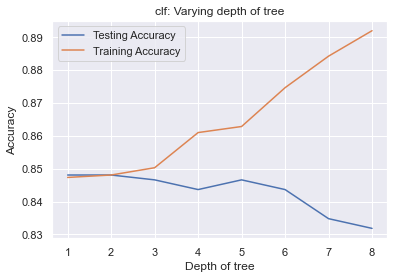

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=15, stratify=y)

# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = tree.DecisionTreeClassifier(max_depth=k)
    # Fit the classifier to the training data
    clf.fit(x_train, y_train)
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(x_train, y_train)
    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(x_test, y_test)

plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

# BEGIN DELIVERABLE 2

In [17]:
# Create function that takes a dataframe, gets a list of its columns, runs through forest regressor test with each column, 
# and returns all results into a dataframe. Used for finding best predictors of TenYearCHD
def forest_preds_finder(data, estimators=100, depth=3, bstrap=True, rstate=51):
    # Change data so that it only includes numerical values
    data=data.select_dtypes(include=['float64','bool','int64'])
    # Create variable that iterates through a df and makes a list of columns, excluding TenYearCHD
    data_cols = [x for x in data.columns if x != 'TenYearCHD']
    for_list = []
    for col in data_cols:
        X = data[ [col] ]
        y = data['TenYearCHD']
        X_train, X_test = X[:round(len(data)*.8)], X[round(len(data)*.2):]
        y_train, y_test = y[:round(len(data)*.8)], y[round(len(data)*.2):]
        model = RandomForestRegressor(n_estimators=estimators, max_depth=depth, bootstrap=bstrap, random_state=rstate)
        model.fit(X_train, y_train)
        # model.predict(X_test)
        y_pred = model.predict(X_test)
        # The mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # The coefficient of determination: 1 is perfect prediction
        r2 = r2_score(y_test, y_pred)
        # Append values into for_list
        for_list.append((col,r2,mse))
    # Write to a new dataframe, df_forest_data
    df_forest_preds=pd.DataFrame(for_list, columns=['Column Name','R-squared','Mean Squared Error'])
    return df_forest_preds

In [18]:
# Create function that takes dataframe from forest_preds_finder, finds best individual predictors, and runs through a forest 
# test with those predictors. Should find the best possible models. Default values were set after some trial and error testing
def forest_test(data, tot_preds=12, estimators=100, depth=25, bstrap=True, rstate=51, train_size=.8):
    # Variable that holds a list of top individual predictors, sorted by R-squared and Mean Squared Error. Print predictors
    forest_preds_list = list(forest_preds_finder(data).sort_values(by=['R-squared','Mean Squared Error'],ascending=False).head(tot_preds)['Column Name'])
    print(f'Predictors:', forest_preds_list)
    # Begin setting variables and parameters for Random Forest test
    X = data[ forest_preds_list ]
    y = data['TenYearCHD']
    # Set sample sizes. Return an error message if train_size is not between 0 and 1
    if train_size >= 1 or train_size<=0:
        return "Error: train_size must be a value between 0 and 1, non-inclusive"
    X_train, X_test = X[:round(len(data)*train_size)], X[round(len(data)*(1-train_size)):]
    y_train, y_test = y[:round(len(data)*train_size)], y[round(len(data)*(1-train_size)):]
    # Execute test with variables that can be changed when running function
    model = RandomForestRegressor(n_estimators=estimators, max_depth=depth, bootstrap=bstrap, random_state=rstate)
    model.fit(X_train, y_train)
    # model.predict(X_test)
    y_pred = model.predict(X_test)
    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    #print('Mean squared error:', mse)
    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    #print('R-Squared:', r2)
    return {'R2':r2,'MSE':mse}

In [19]:
# Run function for each data frame to compare results
('df',forest_test(df)),('df2',forest_test(df2)),('df3',forest_test(df3)),('df4',forest_test(df4))

Predictors: ['sysBP', 'age', 'diaBP', 'prevalentHyp', 'glucose', 'BMI', 'totChol', 'diabetes', 'BPMeds', 'male', 'education', 'heartRate']
Predictors: ['sysBP', 'age', 'diaBP', 'prevalentHyp', 'glucose', 'BMI', 'totChol', 'male', 'BPMeds', 'diabetes', 'heartRate', 'education']
Predictors: ['sysBP', 'age', 'numAgeRanges', 'diaBP', 'prevalentHyp', 'numBPRanges', 'glucose', 'HBP_s2', 'BMI', 'totChol', 'male', 'bpNormal']
Predictors: ['sysBP', 'age', 'diaBP', 'prevalentHyp', 'glucose', 'BMI', 'totChol', 'diabetes', 'BPMeds', 'male', 'education', 'heartRate']


(('df', {'R2': 0.654833219304966, 'MSE': 0.043544218606601355}),
 ('df2', {'R2': 0.6446767166849522, 'MSE': 0.04481339637199339}),
 ('df3', {'R2': 0.63789369385285, 'MSE': 0.04566887166744642}),
 ('df4', {'R2': 0.654833219304966, 'MSE': 0.043544218606601355}))

In [20]:
# Compare results with fewer predictors
forest_test(df,5)

Predictors: ['sysBP', 'age', 'diaBP', 'prevalentHyp', 'glucose']


{'R2': 0.6256864567876287, 'MSE': 0.04722120338530457}

With multiple data frames to utilize, the random forest model was run several times to help understand which model yields the best coefficient of determination (COD) and mean squared error (MSE). For each data frame, the depth of the decision trees was manipulated to see how it would affect the outputs. For this dataset, the numbers improved significantly until around a depth of 20, and then plateaued completely at a depth of 25. For this reason, we chose to use 25 as our default depth level to maximize the model’s COD and minimize the model’s MSE. The number of decision trees (n_estimators) for this dataset is set to 100 because anything above this level provided negligible changes in accuracy. It is also worth mentioning that because the random forest function cannot ingest strings, our custom function excludes all data types outside of bool, int, and float; because of this, df and df4 are effectively the same dataset with this test, as is reflected by both the COD and MSE.
	
By default, train size is 80% and test size is 20%, which results in a COD of 65.5% and MSE of .044 when using df and df4. These train and test set parameters are chosen to keep consistent with previous models, however, we have observed that by increasing to a 90/10 ratio, this model improves COD to about 75.7% and MSE to about .047. 

In terms of chosen predictor variables, a function is created that helps determine the best predictor variables for each data frame. The resulting top predictors for each data frame are not surprising. Factors such as sysBP, age, diaBP, prevalentHyp, glucose, BMI, totChol, diabetes, BPMeds, and male are consistently the top variables the function finds. Using our default parameters, the COD values range from 63.8% to 65.5%, depending on which data frame is used. For this dataset, we expected ‘male’ (gender) to play a larger role in predicting accuracy, however it is ranked consistently on the lower end of the top 10 predictors in each test. This implies that, according to this data, gender does not play a large role in developing heart disease. This may be partially because the dataset contains around 400 more datapoints for non-males. 

Number of total predictors has been set at a default of 12, which was chosen because it gives the highest R-squared (R2) value and lowest Mean Squared Error (MSE). However, the change in quality of prediction is not as significant as it may seem with fewer predictors, as the top five predictors for TenYearCHD on df provide an R2 and MSE of about 0.626 and 0.044, respectively; R2 and MSE on the same model with 12 predictors are about 0.655 and 0.047, respectively. In situations with significantly more data that would require longer waits and more processing power to run these functions, we would likely opt to use a lower default amount of predictors.
	
Also surprising are the MSE values for the random forest models. In each case, the MSE values are very low (<1) in comparison to the previous MSE values above 100. This implies this model is much more reliable than a linear regression model. In terms of COD values, this model ranks between the first two models with a slightly better COD than the linear regression model and significantly less accurate than the single decision tree model.

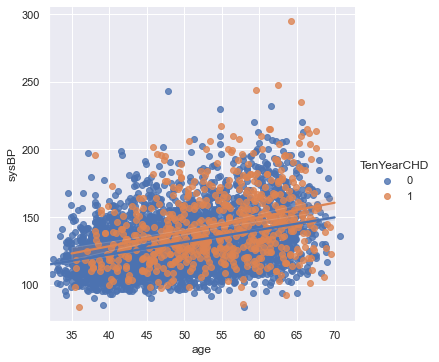

In [46]:
sns.lmplot(data=df4, x='age', y='sysBP', hue='TenYearCHD',x_jitter=True)
plt.show()

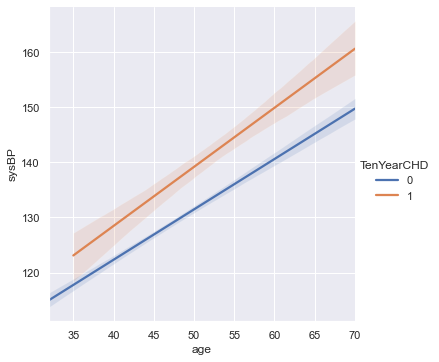

In [45]:
sns.lmplot(data=df4, x='age', y='sysBP', hue='TenYearCHD',x_jitter=True,scatter=False)
plt.show()

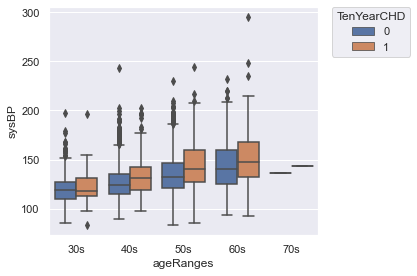

In [22]:
sns.boxplot(data=df, x='ageRanges', y='sysBP', hue='TenYearCHD')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.,title='TenYearCHD')
plt.tight_layout()
plt.show()